In [1]:
!gdown --id 1TVz-3cmMQESfwcQIL35yN9P3-7DLqiBS

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TVz-3cmMQESfwcQIL35yN9P3-7DLqiBS
From (redirected): https://drive.google.com/uc?id=1TVz-3cmMQESfwcQIL35yN9P3-7DLqiBS&confirm=t&uuid=a9132a81-c346-456c-961d-a397c090c9c6
To: /content/sum_data.zip
100% 4.95G/4.95G [01:38<00:00, 50.1MB/s]


In [2]:
!unzip -oqq sum_data.zip

In [3]:
import pandas as pd
import numpy as np
import glob
from tqdm.notebook import tqdm
import cv2
from sklearn.model_selection import train_test_split


from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display
import torchvision.transforms.functional as F


In [4]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [24]:


train_transform = transforms.Compose([
    #transforms.RandomRotation((90, 90)),
    transforms.ColorJitter(),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    #transforms.GaussianBlur(kernel_size=(7, 13), sigma=(9, 11)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    transforms.ToPILImage()
])
null_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

In [26]:
imagenet_data = torchvision.datasets.ImageFolder('sum_data', transform=null_transform)

In [27]:
dict1=imagenet_data.class_to_idx

In [28]:
validation_split = .2
shuffle_dataset = True
random_seed = 42

dataset_size = len(imagenet_data)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split*dataset_size))
if shuffle_dataset:
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(imagenet_data,
                                           batch_size=2,
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(imagenet_data,
                                           batch_size=2,
                                           sampler=valid_sampler)
print(len(train_loader), len(valid_loader))

8071
3229 807


  0%|          | 0/807 [00:00<?, ?it/s]

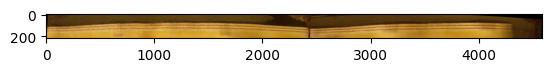

In [29]:
with torch.no_grad():
    for imgs, labels in tqdm(valid_loader):
      #plt.imshow(torch.einsum('cwh->whc', imgs[0]))
      plt.imshow(torch.einsum('cwh->whc', imgs[0]))
      break

Отлично, теперь давайте напишем пару вспомогательных функций для визуализации и тренировки

  0%|          | 0/807 [00:00<?, ?it/s]

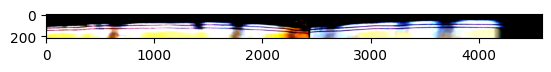

In [20]:
with torch.no_grad():
    for imgs, labels in tqdm(valid_loader):
      #plt.imshow(torch.einsum('cwh->whc', imgs[0]))
      plt.imshow(torch.einsum('cwh->whc', imgs[0]))
      break

## Вспомогательные функции

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history , label='train', zorder=1)

    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [ ]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []

    train_acc_log = []
    val_acc_log = []

    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0

        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()
            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()

            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            train_pred += (y_pred.argmax(1) == labels).sum()
            optimizer.step()

        train_acc_log.append(train_pred / train_size)
        print('почти')
        val_loss = 0.
        val_size = 0

        val_pred = 0.

        model.eval()

        with torch.no_grad():
            for imgs, labels in test_dataloader:

                imgs = imgs.cuda()
                labels = labels.cuda()

                pred = model(imgs)
                loss = criterion(pred, labels)

                val_loss += loss.item()
                val_size += pred.size(0)

                val_pred += (pred.argmax(1) == labels).sum()

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)
        clear_output()
        plot_history(torch.tensor(train_loss_log).cpu().detach().numpy(), val_loss_log, 'loss')
        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модель
Все, перейдем к обучению самой модели. Воспользуемся предобученным резнетом и заменим у него классификатор, а потом будем обучать только его.

In [ ]:
model = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext50_32x4d_swsl')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)


model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

#optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-5)
plist = [{'params': model.parameters(), 'lr': 5.3e-6}]
optimizer = optim.Adam(plist, lr=5.3e-6)

Downloading: "https://github.com/facebookresearch/semi-supervised-ImageNet1K-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext50_32x4-72679e44.pth" to /root/.cache/torch/hub/checkpoints/semi_weakly_supervised_resnext50_32x4-72679e44.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 191MB/s]


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)


model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

#optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-5)
plist = [{'params': model.parameters(), 'lr': 5.3e-6}]
optimizer = optim.Adam(plist, lr=5.3e-6)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


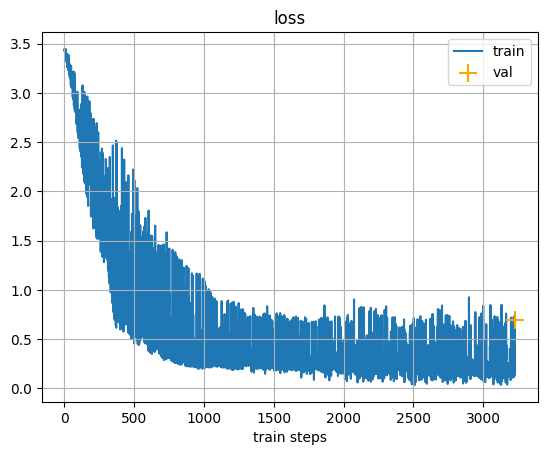

Train loss: 60.30503972956358
Val loss: 69.50070195722094
Train acc: tensor(73.0990, device='cuda:0')
Val acc: tensor(72.6146, device='cuda:0')


KeyboardInterrupt: 

In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model,
                                                                 criterion,
                                                                 optimizer,
                                                                 train_loader,
                                                                 valid_loader,
                                                                 4)

In [ ]:
from typing import Tuple

class F1Score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))

        return f1_score

    @staticmethod
    def calc_f1_count_for_label(predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self.calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, len(labels.unique()) + 1):
            f1, true_count = self.calc_f1_count_for_label(predictions, labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))
        return f1_score

In [ ]:
true_labels = torch.Tensor().cuda()
predictions = torch.Tensor().cuda()


In [ ]:
eazy_score=0

with torch.no_grad():
    for imgs, labels in tqdm(valid_loader):

        imgs = imgs.cuda()
        labels = labels.cuda()

        pred = model(imgs).argmax(dim=1)

        true_labels = torch.cat(
                                    (true_labels, labels)
                                    ,dim=0
                                )
        predictions = torch.cat(
                                    (predictions, pred)
                                    ,dim=0
                                )

#f1_metric = F1Score('macro')
#f1_metric(predictions, true_labels)

  0%|          | 0/807 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
    #for imgs, labels in tqdm(valid_loader):
  image=cv2.imread("image2.png")
  image=valid_transform(image)
  #image = image.cuda()
  print(np.shape(image))
  plt.imshow(torch.einsum('cwh->whc', image))


In [ ]:
with torch.no_grad():
    #for imgs, labels in tqdm(valid_loader):
  image=cv2.imread("image2.png")
  image = test_transform(image)
  #image = image.cuda()
  print(np.shape(image))
  plt.imshow(torch.einsum('cwh->whc', image))


torch.Size([3, 220, 4583])


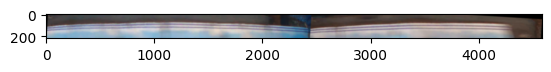

In [ ]:

with torch.no_grad():
    #for imgs, labels in tqdm(valid_loader):
  image=cv2.imread("image2.png")
  image = gaus2_transform(image)
  #image = image.cuda()
  print(np.shape(image))
  plt.imshow(torch.einsum('cwh->whc', image))

In [ ]:
#listOfImageNames = ['dataset/1/1_1.png',
               #     'dataset/1/1_2.png'
                #   ]
#for imageName in listOfImageNames:
   # display(Image(filename=imageName))

In [ ]:
cnt=0
with torch.no_grad():
    for i in tqdm(range(len(true_labels))):
      if true_labels[i].item()==predictions[i].item():

        cnt+=1

  0%|          | 0/1614 [00:00<?, ?it/s]

In [ ]:
eazy_score=cnt/len(true_labels)
eazy_score

0.9684014869888475

In [ ]:
predictions[0].item()

0.0

In [ ]:
import pickle
import torch
torch.save(model, 'model.pt')#Сохраняем

In [ ]:
model=torch.load('model (85).pt')#Загружаем

FileNotFoundError: [Errno 2] No such file or directory: 'model (85).pt'

In [ ]:
classDict = {0:'Есть брак',
            1:'Брака нет' ,
            }

In [ ]:
import time

In [ ]:
#model=torch.load('model (85).pt')
model=model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
def Predict(path):
  image=cv2.imread(path)
  image=valid_transform(image)
  image = image.cuda()
  pred = model(image[None, ...])
  pred_class=pred.argmax().item()
  finish = time.time()
  #print(finish-start)
  return classDict[pred_class]

In [ ]:
output_path = 'dataset/12/12_'

for j in range(355,858):
  path = output_path + str(j) + ".png"
  print(path)
  print(Predict(path))

dataset/12/12_355.png
Одна полоса клея
dataset/12/12_356.png
Одна полоса клея
dataset/12/12_357.png
Заминание
dataset/12/12_358.png
Одна полоса клея
dataset/12/12_359.png
Заминание
dataset/12/12_360.png
Одна полоса клея
dataset/12/12_361.png
Одна полоса клея
dataset/12/12_362.png
Одна полоса клея
dataset/12/12_363.png
Одна полоса клея
dataset/12/12_364.png
Одна полоса клея
dataset/12/12_365.png
Одна полоса клея
dataset/12/12_366.png
Одна полоса клея
dataset/12/12_367.png
Одна полоса клея
dataset/12/12_368.png
Одна полоса клея
dataset/12/12_369.png
Одна полоса клея
dataset/12/12_370.png


KeyboardInterrupt: 